In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
# from utilities3 import LpLoss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
from scipy import linalg
from scipy.interpolate import interp1d

Using backend: pytorch



In [2]:
def solveBetaFunction(x, gamma, amp):
    beta = np.zeros(len(x))
    for idx, val in enumerate(x):
        beta[idx] = amp*math.cos(gamma*math.acos(val))
    return beta

def buildF(x, gamma1, amp1, gamma2, amp2):
    b1 = solveBetaFunction(x, gamma1, amp1)
    b2 = solveBetaFunction(x, gamma2, amp2)
    nx = len(x)
    f = np.zeros((nx, nx))
    for idx, val in enumerate(x):
        for idx2, val2 in enumerate(x):
            if idx <= idx2:
                f[idx][idx2] = b1[idx]*b2[idx2]
    return f

def buildtau(nx,tau):
    tau_matrix = tau * np.ones((nx, nx))
    # tau_matrix = np.triu(tau_matrix)
    tau_matrix = tau_matrix.reshape(1, -1)
    return tau_matrix

def buildCof_int_x_1(x, dx):
    nx = len(x)
    cof_int_x_1 = np.triu(np.ones((nx,nx)))
    cof_int_x_1[:,-1]=1/2*np.ones((1,nx))
    cof_int_x_1= dx*(cof_int_x_1-1/2*np.eye(nx))
    return cof_int_x_1

def buildCof_int_0_x(x, dx):
    nx = len(x)
    cof_int_0_x = np.tril(np.ones((nx,nx)))
    cof_int_0_x[:,0]=1/2*np.ones((1,nx))
    cof_int_0_x= dx*(cof_int_0_x-1/2*np.eye(nx))
    return cof_int_0_x

def findinterpolation(kappabud, spatial1, spatial2):
    fx = interp1d(spatial1, kappabud, kind="cubic")
    kappabudInterp = fx(spatial2)
    return kappabudInterp

def zeroToNan(x):
    for j in range(len(x)):
        for i in range(len(x)):
            if i > j:
                x[i][j] = float('nan')
    return x

def LowTriTozero(x):
    for j in range(len(x)):
        for i in range(len(x)):
            if i > j:
                x[i][j] = float(0)
    return x

def solveControl(u, Kbud, Lbud, Jbud, nx, dx, tau_obs, k):
    return (sum(Kbud*u[0:nx]*dx) +tau_obs*sum(Lbud*u[nx:2*nx]*dx)+k*sum(Jbud*u[2*nx:3*nx]*dx)
            - Kbud[0]*u[0]*dx/2
            - Kbud[nx-1]*u[nx-1]*dx/2
            - tau_obs*Lbud[0]*u[nx]*dx/2
            - tau_obs*Lbud[nx-1]*u[2*nx-1]*dx/2
            - k*Jbud[0]*u[2*nx]*dx/2
            - k*Jbud[nx-1]*u[3*nx-1]*dx/2)

def solveOpenLoop(_, _a, _b, _c, _d, _e, _f, _g):
    return 0

def fastKernelCalc(f, c, tau, tau_obs, x, cof_int_x_1, cof_int_0_x):
    nx = len(x) 
    dx=x[2]-x[1]
    k=tau-tau_obs
    Ntau=int(tau/dx)+1
    K = np.zeros((nx, nx))
    result = 0
    for i in range(nx-2, -1, -1):
        result += (f[[i+1],[i+1]] + f[[i],[i]])*dx/2*(-1)
        K[i,i] = result
    for i in range(nx-2, -1, -1):
        num = nx - i
        A1 = np.diag([-2]*num) + np.diag([1]*(num-1),1)
        A1[[0],[0]] = 1
        A1[[0],[1]] = 0
        A1[[-1],[-1]] = 1

        A121=np.zeros((num,num))
        A122=np.zeros((num,num))
        A121[1:num-1,0:num-1]= f.T[i+1:i-1+num,i:i-1+num]
        A122[0:num-1,0:num-1] = dx*cof_int_0_x[0:num-1,0:num-1] 
        A1 = A1+ A121*A122
        B1=np.zeros((num,1))
        B1[[0],[0]] = K[[i],[i]]
        B1[1:num-1,0] =-K[[i+1],i+1:nx-1].reshape((num-2)) +(dx*f[i,i+1:nx-1]).reshape((num-2))
        if i+ Ntau<nx:
            B1[num-1,0]=sum(cof_int_x_1[i+Ntau-1,:]*K[i+Ntau-1,:]*c)-c[i+Ntau-1]
        else:
            B1[num-1,0]=0
        D=np.linalg.solve(A1,B1)
        K[[i],i:nx]=D.T

    J=np.zeros((nx, nx))
    c_matrix=np.repeat(c[np.newaxis,:], nx, 0)
    J[0:nx,0]=np.sum(cof_int_x_1*c_matrix*K, axis=1)-c[0:nx]
    AJ = np.diag([k+1]*nx) + np.diag([-1]*(nx-1),-1)
    AJ[0,0]=1
    for i in range(nx-2, -1, -1):
        BJ=np.zeros((nx,1))
        BJ[0,0]=J[i,0]
        BJ[1:nx,0]=k*J[i+1,1:nx]
        J[[i],0:nx]=(np.linalg.solve(AJ,BJ)).T
    
    L=np.zeros((nx, nx))
    L[0:nx,0]=J[0:nx,-1]
    AL = np.diag([tau_obs+1]*nx) + np.diag([-1]*(nx-1),-1)
    AL[0,0]=1
    for i in range(nx-2, -1, -1):
        BL=np.zeros((nx,1))
        BL[0,0]=L[i,0]
        BL[1:nx,0]=tau_obs*L[i+1,1:nx]
        L[[i],0:nx]=(np.linalg.solve(AL,BL)).T
    return K, L, J

def solvePDE(tau, tau_obs, c, f, Kbud, Lbud, Jbud, init_condition, x, t, printFreq=500):
    k=tau-tau_obs
    nx = len(x)
    nt = len(t)
    dx=x[1]-x[0]
    dt=t[1]-t[0]
    uu = np.zeros((nt, 3*nx))
    uu[0,:] = init_condition
    for i in range(1, nt):
        if i%int(printFreq) == 0:
            print("Completed:", i, "/", nt, flush=True)
            
        uu[i][0] = solveControl(uu[i-1], Kbud, Lbud, Jbud, nx, dx,tau_obs,k)
        fres = np.zeros(nx)
        for j in range(1, nx):
            fres[j] = sum(f[j][j:nx]*uu[i-1][j:nx])*dx-f[j][j]*uu[i-1][j]*dx/2-f[j][nx-1]*uu[i-1][nx-1]*dx/2
        uu[i][2*nx-1]=uu[i-1][nx-1]
        uu[i][nx:2*nx-1] = uu[i-1][nx:2*nx-1]+dt/(tau_obs*dx)*(uu[i-1][nx+1:2*nx]-uu[i-1][nx:2*nx-1])
        uu[i][3*nx-1]=uu[i-1][nx]
        uu[i][2*nx:3*nx-1] = uu[i-1][2*nx:3*nx-1]+dt/(k*dx)*(uu[i-1][2*nx+1:3*nx]-uu[i-1][2*nx:3*nx-1])
        uu[i][1:nx] = uu[i-1][1:nx] - dt/dx*(uu[i-1][1:nx] - uu[i-1][0:nx-1]) + dt*fres[1:nx] + dt*c[1:nx]*uu[i-1][nx]
    return uu

In [4]:
## time
T = 10
dt = 0.001
nt = int(round(T/dt))+1
temporal = np.linspace(0, T, nt)
## space
X = 1
# dx = dt*a
dx = 0.02
nx = int(round(X/dx))+1
spatial = np.linspace(0, X, nx)

cof_int_x_1 = buildCof_int_x_1(spatial, dx)
cof_int_0_x = buildCof_int_0_x(spatial, dx)

## system parameters
# tau = 1.8
tau_obs = 0.5
# k=tau-tau_obs

# c=1-spatial
# f =buildF(spatial, 5, 3, 5, 3)

In [5]:
# Parameters tranin for K
ndata1 = 20 #tau
#ndata2 = 10 #tau_obs
ndata3 = 20 #f
ndata4 = 20 #c
ndata=ndata1*ndata3*ndata4
epochs =300
ntrain = 7200
ntest = 800
batch_size = 20
gamma = 0.6
learning_rate = 0.0002
step_size= 50
# modes=12
# width=32

In [9]:
# # Dataset generation 
inpArr = []
outArr = []
tauArr = []
# tauobsArr = []
fArr = []
cArr = []
# # tau=1
for i in range(ndata1):
        tauArr.append(np.random.uniform(0.8, 2))

for i in range(ndata3):
        f = buildF(spatial, np.random.uniform(3, 6), 3, np.random.uniform(3, 6), 3)
        fArr.append(f)
for i in range(ndata4):
        c = solveBetaFunction(spatial, np.random.uniform(3, 6), 1)
        c = c-c[-1]
        cArr.append(c) 
jj=0
for tau in tauArr:
        for f in fArr:
                for c in cArr:
                        jj+=1
                        if jj % 1000 == 0:
                                print("Completed", jj, "/", ndata)
                        K,L,J=fastKernelCalc(f, c, tau, tau_obs, spatial, cof_int_x_1, cof_int_0_x)
                        tau_matrix=buildtau(nx,tau)
                        c_matrix=buildtau(nx,c)
                        tempin=np.concatenate([tau_matrix,f.reshape(1,-1),c_matrix.reshape(1,-1)],axis=1)
                        tempout = np.concatenate([K.reshape(1,-1)],axis=1)
                        inpArr.append(tempin)
                        outArr.append(tempout)

##########
x = np.array(inpArr) 
y = np.array(outArr)
x = x.reshape(x.shape[0],3*nx*nx)
y = y.reshape(y.shape[0],nx*nx)
np.savetxt("xk.dat", x)
np.savetxt("yk.dat", y)

Completed 1000 / 8000
Completed 2000 / 8000
Completed 3000 / 8000
Completed 4000 / 8000
Completed 5000 / 8000
Completed 6000 / 8000
Completed 7000 / 8000
Completed 8000 / 8000


In [10]:
inpArr = np.loadtxt("xk.dat", dtype=np.float32)
outArr = np.loadtxt("yk.dat", dtype=np.float32)
x = np.array(inpArr)
y = np.array(outArr)

In [30]:
inpArr = np.loadtxt("x50_0706k1.dat", dtype=np.float32)
outArr = np.loadtxt("y50_0706k1.dat", dtype=np.float32)
x = np.array(inpArr)
y = np.array(outArr)

In [11]:
grids0 = []
grids0.append(np.linspace(0, 1, nx, dtype=np.float32))
grids0.append(np.linspace(0, 1, nx, dtype=np.float32))
grid0 = np.vstack([xx.ravel() for xx in np.meshgrid(*grids0)]).T
grid = torch.from_numpy(grid0).cuda()

In [31]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [13]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [32]:
class BranchNet1(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(12800, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 3, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [17]:
class BranchNet2(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(in_channels=4, out_channels=64,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128,
                       kernel_size=5, stride=2)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(12800, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 4, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [33]:
# Define a sequential torch network for batch and trunk. Can use COV2D which we will show later
dim_x = 2
# m = int(nx*(nx+1)/2)
m1 = 3*nx*nx
# m = 4*nx*nx
branchk1 = BranchNet1(nx)
# branchk2 = BranchNet2(nx)
# branchk3 = BranchNet2(nx)
# model = dde.nn.DeepONetCartesianProd([m,  128, 40], [dim_x, 40, 40], "relu", "Glorot normal").cuda()
modelk1 = dde.nn.DeepONetCartesianProd([m1, branchk1], [dim_x, 128,  256], "relu", "Glorot normal").cuda()
# modelk2 = dde.nn.DeepONetCartesianProd([m, branchk2], [dim_x, 128,  256], "relu", "Glorot normal").cuda()
# modelk3 = dde.nn.DeepONetCartesianProd([m, branchk3], [dim_x, 128,  256], "relu", "Glorot normal").cuda()
print(count_params(modelk1))
# print(count_params(modelk2))
# print(count_params(modelk3))

6928641


In [34]:
optimizer = torch.optim.Adam([
	{'params': modelk1.parameters(), 'lr': learning_rate,} 
	])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [35]:
# loss = nn.MSELoss()
loss = torch.nn.SmoothL1Loss(reduction='mean', beta=1.0)

train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    modelk1.train()
    # modelk2.train()
    # modelk3.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        # x1=x[:,nx*nx:4*nx*nx]
        # y1=y[:,0:nx*nx]
        # y2=y[:,nx*nx:2*nx*nx]
        # y3=y[:,2*nx*nx:3*nx*nx]
        optimizer.zero_grad()
        out = modelk1((x, grid))
        # out2 = modelk2((x, grid))
        # out3 = modelk3((x, grid))
        lp = loss(out.view(batch_size, -1), y.view(batch_size, -1)) 
        # + loss(out2.view(batch_size, -1), y2.view(batch_size, -1)) \
        # + loss(out3.view(batch_size, -1), y3.view(batch_size, -1))
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    modelk1.eval()
    # modelk2.eval()
    # modelk3.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            # x1=x[:,nx*nx:4*nx*nx]
            # y1=y[:,0:nx*nx]
            # y2=y[:,nx*nx:2*nx*nx]
            # y3=y[:,2*nx*nx:3*nx*nx]
            out = modelk1((x, grid))
            # out2 = modelk2((x, grid))
            # out3 = modelk3((x, grid))
            test_loss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()  
            # +loss(out2.view(batch_size, -1), y2.view(batch_size, -1)).item() \
            # +loss(out3.view(batch_size, -1), y3.view(batch_size, -1)).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, np.mean(train_lossArr[-50:]), np.mean(test_lossArr[-50:]))

    

0 2.2602550940355286 0.12912336093270116 0.04144688448868692
50 2.2352762449881993 0.0021768339237140835 0.0021890662564255764
100 2.0161927840090357 0.00014256654071363706 0.00016339663867256604
150 2.0312700350186788 5.805200849752308e-05 6.288384623167076e-05
200 2.2765031610033475 3.074836039640003e-05 2.9087100233027744e-05
250 2.0871886130189523 1.90710496189139e-05 1.9721580574241673e-05


Avg Epoch Time: 2.149048568509946
Final Testing Loss: 15.181366682052612
Final Training Loss: 0.004782951879860775


Text(0.5, 0, '$\\mathrm{epoch}$')

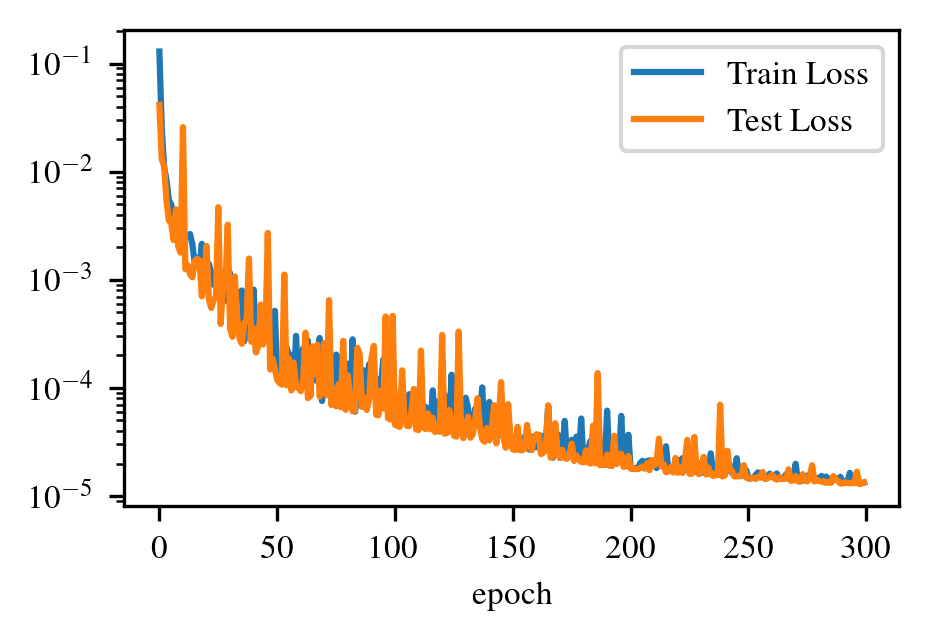

In [36]:
# Display Model Details
plt.figure(figsize=(1000 / 300, 618 / 300), dpi=300)
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(train_lossArr, label="Train Loss",linewidth=1.5)
plt.plot(test_lossArr, label="Test Loss",linewidth=1.5)
plt.yscale("log")
plt.legend(fontsize="8")

testLoss = 0
trainLoss = 0
with torch.no_grad():
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        out = modelk1((x, grid))
        out = out.reshape((out.shape[0], out.shape[1]))
        trainLoss +=  loss(out.view(batch_size, -1), y.view(batch_size, -1)).item() 
        
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
        out = modelk1((x, grid))
        out = out1.reshape((out.shape[0], out.shape[1]))
        testLoss +=   loss(out.view(batch_size, -1), y.view(batch_size, -1)).item() 
    
    
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))
print("Final Testing Loss:", testLoss)
print("Final Training Loss:", trainLoss)
plt.tick_params(labelsize=8)
plt.xlabel(r"$\mathrm{epoch}$",fontsize = 8 )
# plt.savefig('img/Kloos.eps', dpi=300,bbox_inches='tight')


In [37]:
tau = 1
tau_obs = 0.5
k=tau-tau_obs 
c=solveBetaFunction(spatial, 5, 1)
c = c-c[-1]
f =buildF(spatial, 5, 3, 5, 3)

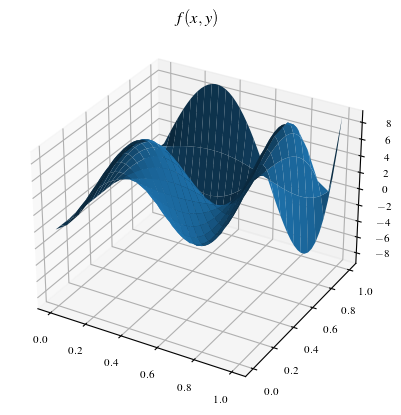

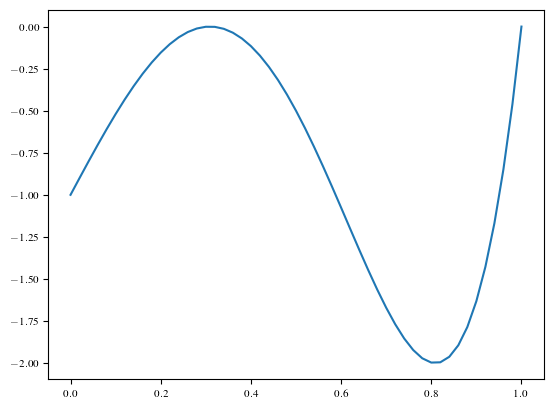

In [38]:
meshy, meshx = np.meshgrid(spatial, spatial)
fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(meshx, meshy, zeroToNan(f))
ax.set_title(r"$f(x,y)$")

fig_intep=plt.figure()
plt.plot(spatial, c)

In [39]:
f =buildF(spatial, 5, 3, 5, 3)
K, L, J=fastKernelCalc(f, c, tau, tau_obs, spatial, cof_int_x_1, cof_int_0_x)

In [40]:
f =buildF(spatial, 5, 3, 5, 3)
tau_matrix=buildtau(nx,tau)
tauobs_matrix=buildtau(nx,tau_obs)
c_matrix=buildtau(nx,c)
xdata=np.concatenate([tauobs_matrix,tau_matrix,f.reshape(1,-1),c_matrix.reshape(1,-1)],axis=1)
 
xdata = np.array(xdata, dtype=np.float32)
xdata = torch.from_numpy(xdata.reshape((1, 4*nx*nx))).cuda()

In [41]:
xdata1=xdata[:,nx*nx:4*nx*nx]

In [42]:
k1= modelk1((xdata1, grid))
k1 = k1.detach().cpu().numpy().reshape(1, nx*nx)
k1=k1.reshape(nx,nx)

In [23]:
# k1= modelk1((xdata1, grid))
# k1 = k1.detach().cpu().numpy().reshape(1, nx*nx)
# k2= modelk2((xdata, grid))
# k2 = k2.detach().cpu().numpy().reshape(1, nx*nx)
# k3= modelk3((xdata, grid))
# k3 = k3.detach().cpu().numpy().reshape(1, nx*nx)
####
# k1=k1.reshape(nx,nx)
# k2=k2.reshape(nx,nx)
# k3=k3.reshape(nx,nx)

Text(0.5, 0.92, '$K-\\hat{K}$')

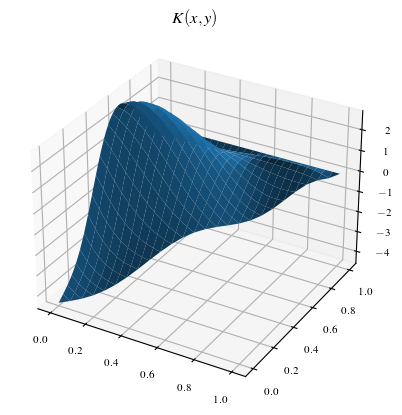

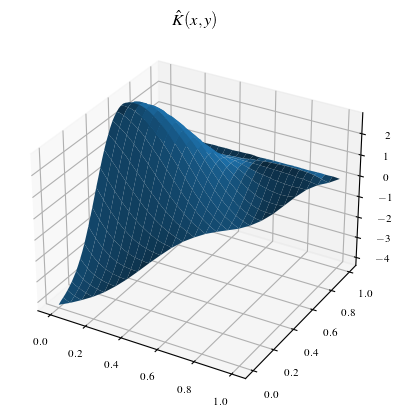

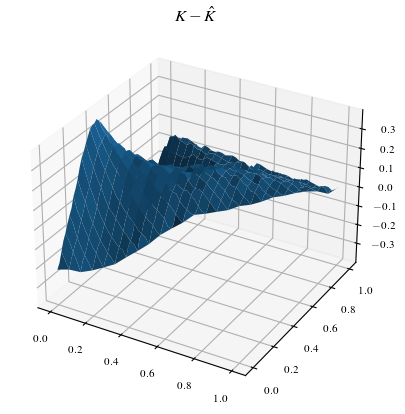

In [43]:
###
fig5 = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(meshx, meshy, zeroToNan(K))
ax.set_title(r"$K(x,y)$")
fig6 = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(meshx, meshy, zeroToNan(k1))
ax.set_title(r"$\hat{K}(x,y)$")
fig7 = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(meshx, meshy, zeroToNan(K-k1))
ax.set_title(r"$K-\hat{K}$")

In [ ]:
# path1='./Model/cftauToCtrlTorchMode1.pth' 
# torch.save(modelk1.state_dict(), path1)